In [10]:
import xarray as xr
import rioxarray
from CMIP6_IO import CMIP6_IO
from dask.distributed import Client
from pathlib import Path
from typing import List, Dict
import matplotlib.pyplot as plt
import geopandas as gdp
from shapely.geometry import box, mapping

## Create plot of models and their realizations and compare with ensemble
This script will loop over all CMIP6 models and the realization combinations to create plots showing the various variables as to how each model and realization is able to cpmature teh dynbamics and they compare. For example, we plot 10 realizations of the CanESM5 model and see how the spread is within the same model. The script compares obserations of sea surface temperature with the models. The script can plot any model variable including:

`var_names = ["par","uv","uvb", "uvi", "uva", "siconc","sithick","sisnthick","sisnconc", "tos"]`

The output figures are stored under `Figures` folder.
Used to create `Figure 2` in paper `Climate change impacts  on ocean light in Arctic ecosystems beyond sea ice.`

In [11]:
import numpy as np
import gcsfs

def get_ersst(var_name: str):
    bucketname = "actea-shared"
    zarr_path = f"gs://{bucketname}/zarr/ersst.v5"
    fs = gcsfs.GCSFileSystem(project="downscale")
    mapper = fs.get_mapper(zarr_path)
    fs = gcsfs.GCSFileSystem(project="downscale")
    ds = xr.open_zarr(mapper, consolidated=True) #.sel(time=slice(obs_start, obs_end))
    if var_name == "tos":
        if "latitude" in list(ds.variables):
            ds = ds.rename({"latitude": "lat", "longitude": "lon"})
        if "analysed_sst" in list(ds.variables):
            ds = ds.rename({"analysed_sst": var_name})
        if "TEMP" in list(ds.variables):
            ds = ds.rename({"TEMP": var_name})
    for item in ["time_bnds", "lev", "nv"]:
        if item in list(ds.keys()):
            if item == "lev":
                ds = ds.isel(lev=0)
                ds = ds.drop_vars([item])
            else:
                ds = ds.drop_vars([item])
    return ds


def get_G10010_SIBT1850(var_name: str):
    # Add the G10010_SIBT1850 siconc
    bucketname = "actea-shared"
    zarr_path = f"gs://{bucketname}/zarr/G10010_SIBT1850/"
    fs = gcsfs.GCSFileSystem(project="downscale")
    mapper = fs.get_mapper(zarr_path)
    fs = gcsfs.GCSFileSystem(project="downscale")
    ds = xr.open_zarr(mapper, consolidated=True) 
    ds = ds.rename({"latitude": "lat", "longitude": "lon"})
    return (ds.rename({"seaice_conc": "siconc"})["siconc"]).to_dataset(name="siconc")
            
def get_hadlsst_dataset(var_name: str):
    bucketname = "actea-shared"
    zarr_path = f"gs://{bucketname}/zarr/HadlSST_sst"
   
    fs = gcsfs.GCSFileSystem(project="downscale")
        
    mapper = fs.get_mapper(zarr_path)
    ds = xr.open_zarr(mapper, consolidated=True) #.sel(time=slice(obs_start, obs_end))
    if var_name == "tos":
        if "latitude" in list(ds.variables):
            ds = ds.rename({"latitude": "lat", "longitude": "lon"})
        if "analysed_sst" in list(ds.variables):
            ds = ds.rename({"analysed_sst": var_name})
        if "TEMP" in list(ds.variables):
            ds = ds.rename({"TEMP": var_name})
    for item in ["time_bnds", "lev", "nv"]:
        if item in list(ds.keys()):
            if item == "lev":
                ds = ds.isel(lev=0)
                ds = ds.drop_vars([item])
            else:
                ds = ds.drop_vars([item])
    # SST has fill_value of -1000 - converting to np.nan
    ds = xr.where(ds == -1000, np.nan, ds)
    
    ds = ds.reindex(lat=list(reversed(ds.lat)))
    return ds.transpose("time", "lat", "lon")

def get_cora_dataset(var_name: str):
    bucketname = "actea-shared"
    zarr_path = f"gs://{bucketname}/zarr/cora5.2/temp"
   
    fs = gcsfs.GCSFileSystem(project="downscale")
        
    mapper = fs.get_mapper(zarr_path)
    ds = xr.open_zarr(mapper, consolidated=True) #.sel(time=slice(obs_start, obs_end))
   
    ds = ds.isel(depth=0) # 0=1m, 2=5m, 3=1.00e+01
    if var_name == "tos":
        if "latitude" in list(ds.variables):
            ds = ds.rename({"latitude": "lat", "longitude": "lon"})
        if "analysed_sst" in list(ds.variables):
            ds = ds.rename({"analysed_sst": var_name})
        if "TEMP" in list(ds.variables):
            ds = ds.rename({"TEMP": var_name})
    for item in ["time_bnds", "lev", "nv"]:
        if item in list(ds.keys()):
            if item == "lev":
                ds = ds.isel(lev=0)
                ds = ds.drop_vars([item])
            else:
                ds = ds.drop_vars([item])

    return ds.transpose("time", "lat", "lon")
 
def collect_ds(scenario: str, var_name: str, ds_list: Dict, source_ids: List):
    max_models=300
    io = CMIP6_IO()
    counter=0

    if var_name not in ["tos", "siconc", "sithick", "tas", "sisnthick", "sisnconc", "uas", "vas"]:
        lightpath = "light/ncfiles"
    else:
        lightpath = f"light/{scenario}"
        
    current = f"{lightpath}"
    file_on_gcs = io.list_dataset_on_gs(current)
  
    # Loop over all files and filter on the models defined in source_ids.
    for f in file_on_gcs:
        
        var_name_mod = var_name
        if var_name not in ["tos", "siconc", "sithick", "tas", "sisnthick", "sisnconc", "uas", "vas"]:
            var_name_mod = f"{var_name}_"
        # Filter to only use the models we prefer
        if any(model in f for model in source_ids) and var_name_mod in f and "uv_srf" not in f and scenario in f:
            if counter >= max_models:
                pass
            else:
                p = Path(f).name
                model = p.split("_")[1] + "_" + p.split("_")[2]
                if "MPI-ESM1-2-HR_r2i1p1f1" not in f and scenario == "ssp585":
                    ds = io.open_dataset_on_gs(f)
                
                    print("=======")
                    print(model)
                    
                    ds_resampled = ds[var_name]
                    ds_list[model] = ds_resampled
                    #print("PERIOD", ds_resampled.time.values[0], ds_resampled.time.values[-1])
                    counter+=1
                else:
                    print(f"Skipping {f}")
            
    # Add the ensemble weighted
    if var_name in ["tos"]:
        f = f"{lightpath}/ensemble/CMIP6_ensemble_stats_{scenario}_{var_name}_weighted.nc"
    else:
        f = f"{lightpath}/ensemble/CMIP6_ensemble_stats_{scenario}_{var_name}_weighted.nc"
    ds = io.open_dataset_on_gs(f)

    ds = ds.rename({f"{var_name}_mean": f"{var_name}"})
    ds_list["ensemble_weighted"] = ds[var_name]
    if var_name in ["tos"]:
        f = f"{lightpath}/ensemble/CMIP6_ensemble_stats_{scenario}_{var_name}.nc"
    else:
        f = f"{lightpath}/ensemble/CMIP6_ensemble_stats_{scenario}_{var_name}.nc"
    ds = io.open_dataset_on_gs(f)
   
    ds = ds.rename({f"{var_name}_mean": f"{var_name}"})
    ds_list["ensemble_unweighted"] = ds[var_name]
    
    return ds_list

In [12]:
def plot_models(ds_list: Dict, var_name: str, shdf_sel, scenario: str, LME: str):
        _, ax = plt.subplots(figsize=(16,8))
        
        saved_model_name = None
        color_index=0      
        for model in ds_list.keys():
                
                ds = ds_list[model]
                if "x" in ds.dims:
                        ds.rio.set_spatial_dims(y_dim="y", x_dim="x", inplace=True)
                else:
                        ds.rio.set_spatial_dims(y_dim="lat", x_dim="lon", inplace=True)
                ds.rio.write_crs(4326,  inplace=True)
                clipped = ds.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=ds.rio.crs)
                if "x" in ds.dims:
                        clipped = clipped.rename({"x": "lon", "y": "lat"}) 
                
                clipped = clipped.resample(time="A").mean()
                clipped = clipped.mean({"lat","lon"})
                
                colors =  plt.cm.tab20( (4./3*np.arange(20*3/4)).astype(int) )
                model_name = model.split("_")[0]

                if saved_model_name is None or saved_model_name != model_name:
                        saved_model_name = model_name
                        color=colors[color_index]
                        color_index+=1
                linewidth=0.6
                alpha=0.6
                print(f"Running calculations and plotting {model}")        
                
                if model in ["ensemble_weighted"]:
                        color="tab:orange"
                        linewidth=2.5
                        alpha=1.0
                if model in ["ensemble_unweighted"]:
                        color="tab:blue"
                        linewidth=2.5
                        alpha=1.0
                
                ax.plot(clipped.time.values,
                        clipped,
                        linewidth=linewidth,
                        color=color,
                        alpha=alpha,
                        label=f"{model}")
                
        if var_name in ["siconc"]:
                use_obs = False
                if use_obs:
                        obs_an = get_G10010_SIBT1850(var_name)
                        
                        obs_an.rio.set_spatial_dims(y_dim="lat", x_dim="lon", inplace=True)
                        obs_an.rio.write_crs(4326,  inplace=True)
                                
                        clipped = obs_an.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=obs_an.rio.crs)
                        clipped=clipped.sel(time=slice("1950-01-01","2021-01-01"))
                
                        print(f"Running calculations and plotting G10010_SIBT1850")       
                        clipped["siconc"] = clipped["siconc"] * 100.0
                        clipped["siconc"] = xr.where(clipped["siconc"] > 100, 100, clipped["siconc"])
                        clipped["siconc"]= xr.where(clipped["siconc"] < 0, 0, clipped["siconc"])
        
                        clipped = clipped.resample(time="A").mean() 
                        clipped = clipped.mean({"lat","lon"}) 
                
                        ax.plot(clipped.time.values,
                                        clipped[var_name],
                                        linewidth=2.5,
                                        color="black",
                                        alpha=1.0,
                                        label="G10010_SIBT1850",
                                        linestyle='dashed')  
                         
        if var_name in ["tos"]:
                # Finally add the observations
        
                use_cora = False
                if use_cora:
                        # CORA5.2 -----------------
                        obs_an = get_cora_dataset(var_name)
                        obs_an.rio.set_spatial_dims(y_dim="lat", x_dim="lon", inplace=True)
                        obs_an.rio.write_crs(4326,  inplace=True)
                        
                        clipped = obs_an.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=obs_an.rio.crs)
                        clipped=clipped.sel(time=slice("1950-01-01","2021-01-01"))
                
                        print(f"Running calculations and plotting CORA")       
                        
                        clipped = clipped.resample(time="A").mean() 
                        clipped = clipped.mean({"lat","lon"}) 
                        
                        ax.plot(clipped.time.values,
                                clipped[var_name],
                                linewidth=2.5,
                                color="black",
                                alpha=1.0,
                                label="CORA5.2",
                                linestyle='dashed')
                        
                # ERSSTv5 --------------------
                obs_an = get_ersst(var_name)
                obs_an.rio.set_spatial_dims(y_dim="lat", x_dim="lon", inplace=True)
                obs_an.rio.write_crs(4326,  inplace=True)

                clipped = obs_an.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=obs_an.rio.crs)  
                clipped = clipped.sel(time=slice("1950-01-01","2021-01-01")).mean({"lat","lon"}) 
                clipped = clipped.resample(time="A").mean() 
                print(f"Running calculations and plotting ERSSTv5")       
        
                ax.plot(clipped.time.values,
                        clipped["sst"],
                        linewidth=2.5,
                        color="tab:red",
                        alpha=1.0,
                        label="NOAA ERSSTv5",
                        linestyle='dashed')
                
        if var_name == "par":
                plt.ylabel(r"Irradiance ($W m^{-2}$)", fontsize=14)
                loc = 'upper left'
        elif var_name == "uv":
                plt.ylabel(r"UV ($W m^{-2}$)", fontsize=14)
                loc = 'upper left'
        elif var_name == "uvb":
                plt.ylabel(r"Irradiance ($W m^{-2}$)", fontsize=14)
                loc = 'upper right'
        elif var_name == "siconc":
                plt.ylabel(r"Sea ice concentration ($percent$)", fontsize=14)
                loc = 'lower left'
        elif var_name == "sithick":
                plt.ylabel(r"Sea ice thickness ($m$)", fontsize=14)
                loc = 'upper right'
        elif var_name == "sisnthick":
                plt.ylabel(r"Sea ice snow thickness ($m$)", fontsize=14)
                loc = 'upper right'
        elif var_name == "sisnconc":
             #   plt.ylabel(r"Sea ice snow concentration ($percent$)", fontsize=14)
                loc = 'upper right'
        elif var_name == "tos":
             #   plt.ylabel(r"Ocean temperature ($^{o}C$)", fontsize=14)
                loc='upper left'
        else:
                loc = 'upper left'
        if var_name == "tos" and LME=='Northern Bering - Chukchi Seas':
                ax.legend(title="Model-scenario",fontsize=13, title_fontsize=16, loc=loc, ncol=2,  labelspacing=0.05)
                
     #   plt.xlabel(r"Year", fontsize=14)
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        plotfile=f"Figures/{var_name}_comparison_members_vs_ensemble_{scenario}_{LME}.png"
        if Path(plotfile).exists():
                Path(plotfile).unlink()
        plt.savefig(plotfile, dpi=300, bbox_inches='tight')
        print(f"Saved to plotfile {plotfile}")

def get_lme_polygon(LME: str):
    lme_file = "gs://actea-shared/Shapefiles/LME66/LMEs66.shp"
    shdf = gdp.read_file(lme_file)
    shdf_4326 = shdf.to_crs(epsg=4326)
    return shdf_4326[shdf_4326["LME_NAME"] == LME]

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ssp585/par_CanESM5_r10i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
CanESM5_r10i1p2f1
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ssp585/par_CanESM5_r1i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
CanESM5_r1i1p2f1
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ssp585/par_CanESM5_r2i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
CanESM5_r2i1p2f1
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ssp585/par_CanESM5_r3i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
CanESM5_r3i1p2f1
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ssp585/par_CanESM5_r7i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
CanESM5_r7i1p2f1
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ssp585/par_CanESM5_r9i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
CanESM5_r9i1p2f1
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ssp585/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
MPI-ESM1-2-HR_r1i1p1f1

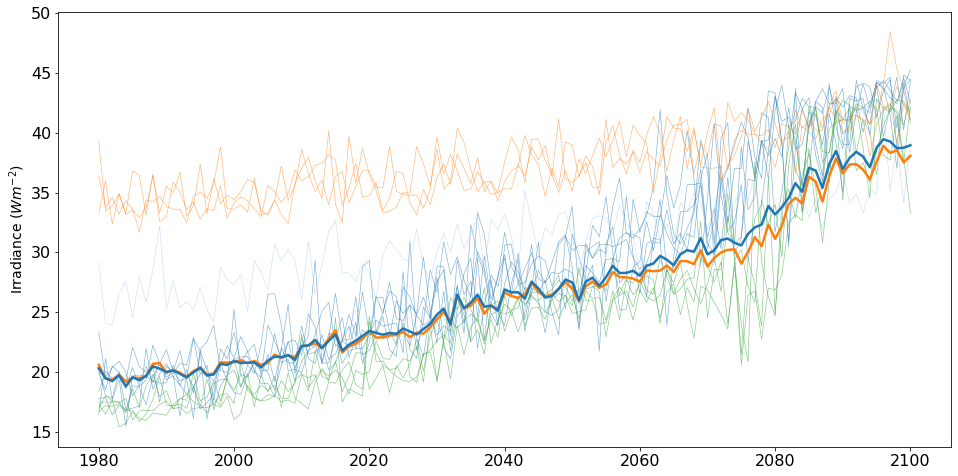

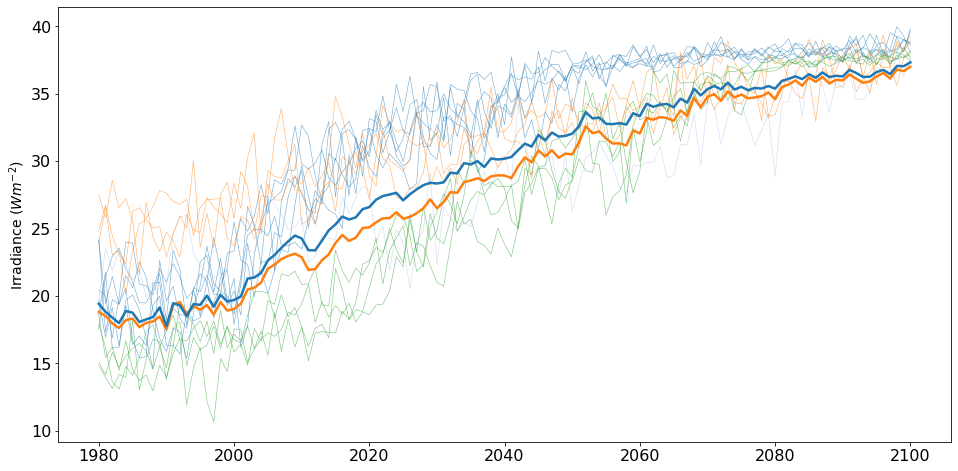

In [13]:
LMES = ["Barents Sea"]

LMES = ["Northern Bering - Chukchi Seas","Barents Sea"]
# Define what models, scenarios, and variables to calculate ensemble files from

source_ids = ["MPI-ESM1-2-HR","MPI-ESM1-2-LR", "CanESM5", "UKESM1-0-LL"]
scenarios=["ssp585"]
var_names = ["par","uv","uvb", "uvi_", "uva_", "uv_srf_"]  # ,"_tos.nc","_siconc.nc"]
var_names = ["siconc","sithick","sisnthick","sisnconc"] #, "_tos.nc","_siconc.nc"]
var_names = ["par"] #,"par","uv","uvb"]
for LME in LMES:
    shdf_sel = get_lme_polygon(LME)

    for scenario in scenarios:
        for var_name in var_names:
        
            ds_list = {}
            ds_list = collect_ds(scenario, var_name, ds_list, source_ids)
            print(ds_list.keys())
            print(f"Number of model-scenario combinations: {len(ds_list.keys())}")

            plot_models(ds_list, var_name, shdf_sel, scenario, LME)

<Figure size 936x576 with 0 Axes>

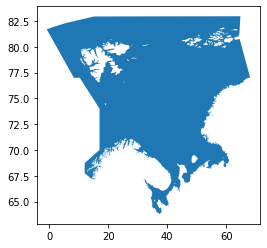

<xarray.Dataset>
Dimensions:      (lat: 77, lon: 272, time: 216)
Coordinates:
  * lat          (lat) float32 82.88 82.62 82.38 82.12 ... 64.38 64.12 63.88
  * lon          (lon) float32 0.125 0.375 0.625 0.875 ... 67.38 67.62 67.88
  * time         (time) datetime64[ns] 2000-01-16 2000-02-16 ... 2017-12-16
    spatial_ref  int64 0
Data variables:
    siconc       (time, lat, lon) float64 dask.array<chunksize=(1, 77, 272), meta=np.ndarray>
<xarray.Dataset>
Dimensions:      (lat: 77, lon: 272)
Coordinates:
  * lat          (lat) float32 82.88 82.62 82.38 82.12 ... 64.38 64.12 63.88
  * lon          (lon) float32 0.125 0.375 0.625 0.875 ... 67.38 67.62 67.88
    spatial_ref  int64 0
Data variables:
    siconc       (lat, lon) float64 dask.array<chunksize=(77, 272), meta=np.ndarray>


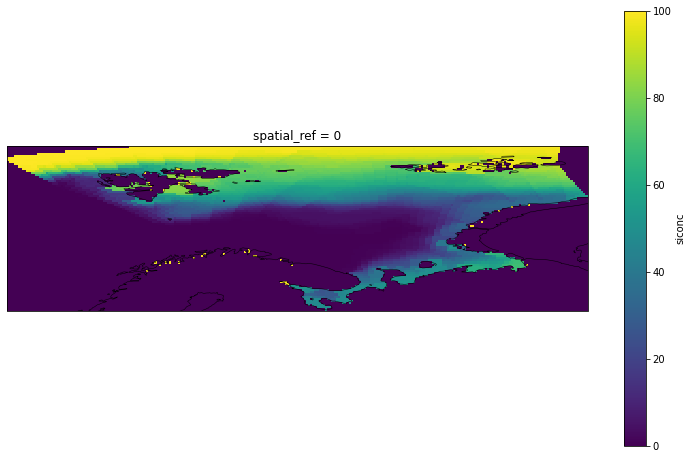

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
fig = plt.figure(figsize=(13, 8))

obs_an = get_G10010_SIBT1850(var_name)
          
#obs_an = get_hadlsst_dataset()
obs_an.rio.set_spatial_dims(y_dim="lat", x_dim="lon", inplace=True)
obs_an.rio.write_crs(4326,  inplace=True)
shdf_sel.plot()
plt.show()
ds = obs_an.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=obs_an.rio.crs)  
ds = ds.sel(time=slice("2000-01-01","2018-01-01"))

ds["siconc"] = ds["siconc"] * 100.0
ds["siconc"] = xr.where(ds["siconc"] > 100, 100, ds["siconc"])
ds["siconc"]= xr.where(ds["siconc"] < 0, 0, ds["siconc"])
print(ds)
ds = ds.mean("time")
print(ds)

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
ds.siconc.plot(ax=ax)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=21)
plt.show()